IN THIS NOTEBOOK, CORRELATION ANALYSIS BETWEEN EACH OF THE TARGET SPEECH FEATURES (MFCC AND X-VECTOR), AND DELTA BIC ARE CONDUCTED

STEP 1: load the data and make the selected segments in pairs to obtain Delta BIC value

In [ ]:
import pandas as pd

loaded_segment_df = pd.read_hdf("/home/zmi/training notebook/features_selected_segments.h5", key='df')

In [ ]:
#pair the segments
import random
import numpy as np

pair_info = []

for file_name in loaded_segment_df['file'].unique():
    file_segments = loaded_segment_df[loaded_segment_df['file'] == file_name]

    if len(file_segments) < 150:
        raise ValueError(f"Not enough segments to create 75 pairs for file: {file_name}")

    shuffled_segments = random.sample(list(file_segments.index), len(file_segments))

    for i in range(0, len(shuffled_segments), 2):
        index1 = shuffled_segments[i]
        index2 = shuffled_segments[i + 1]

        mfcc1 = file_segments.loc[index1, 'mfcc']
        mfcc2 = file_segments.loc[index2, 'mfcc']

        xvector1 = file_segments.loc[index1, 'xvector']
        xvector2 = file_segments.loc[index2, 'xvector']

        pair_info.append({
              'file': file_name,
              'segment_1': index1,
              'segment_2': index2,
              'mfcc1': mfcc1,
              'mfcc2': mfcc2,
              'xvector1':xvector1,
              'xvector2':xvector2,
          })

pairs_df = pd.DataFrame(pair_info)

STEP 2: prepare the parameters that will be used for correlation analysis, including the cosine similarity of MFCCs of paired samples, X-vectors of paired samples, and Delta BIC values of paired samples

In [ ]:
#calculate the euclidean distance and the cosine similarity of mfcc pairs and xvectors pairs
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

euc_distance_mfcc = []
euc_distance_xvector = []
cos_sim_mfcc = []
cos_sim_xvector = []

for index, row in pairs_df.iterrows():
    mfcc1 = np.array(row['mfcc1'])
    mfcc2 = np.array(row['mfcc2'])
    mfcc1_mean = np.mean(mfcc1, axis=1)
    mfcc2_mean = np.mean(mfcc2, axis=1)

    xvector1 = np.array(row['xvector1'])
    xvector2 = np.array(row['xvector2'])
    xvector1_mean = np.mean(xvector1, axis=0)
    xvector2_mean = np.mean(xvector2, axis=0)

    euclidean_distance_mfcc = np.linalg.norm(mfcc1_mean - mfcc2_mean)
    euc_distance_mfcc.append(euclidean_distance_mfcc)

    cosine_similarity_mfcc = cosine_similarity(mfcc1_mean, mfcc2_mean)
    cos_sim_mfcc.append(cosine_similarity_mfcc)

    euclidean_distance_xvector = np.linalg.norm(xvector1_mean - xvector2_mean)
    euc_distance_xvector.append(euclidean_distance_xvector)

    cosine_similarity_xvector = cosine_similarity(xvector1_mean, xvector2_mean)
    cos_sim_xvector.append(cosine_similarity_xvector)

pairs_df['euclidean_distance_mfcc'] = euc_distance_mfcc
pairs_df['euclidean_distance_xvector'] = euc_distance_xvector
pairs_df['cosine_similarity_mfcc'] = cos_sim_mfcc
pairs_df['cosine_similarity_xvector'] = cos_sim_xvector

In [ ]:
#compute the delta bic for each pair
from sklearn.mixture import GaussianMixture

def compute_bic(features, n_components):
    n_components = min(n_components, features.shape[0])
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(features)
    log_likelihood = gmm.score(features) * len(features)
    n_params = gmm.means_.size + gmm.covariances_.size + gmm.weights_.size
    bic = -2 * log_likelihood + np.log(len(features)) * n_params
    return bic

#reshaping is not necessary if the features are already 2D (data points x features)
def reshape_for_gmm(feature):
    if len(feature.shape) == 1:
        return feature.reshape(-1, 1)
    return feature

def pad_to_match_shape(mfcc1, mfcc2):
    max_len = max(mfcc1.shape[1], mfcc2.shape[1])

    #pad both MFCCs to the same length(pad to the right side)
    mfcc1_padded = np.pad(mfcc1, ((0, 0), (0, max_len - mfcc1.shape[1])), mode='constant', constant_values=0)
    mfcc2_padded = np.pad(mfcc2, ((0, 0), (0, max_len - mfcc2.shape[1])), mode='constant', constant_values=0)

    return mfcc1_padded, mfcc2_padded

delta_BICs_mfcc = []
delta_BICs_xvector = []

for _, row in pairs_df.iterrows():
    mfcc1 = reshape_for_gmm(np.array(row['mfcc1']))
    mfcc2 = reshape_for_gmm(np.array(row['mfcc2']))

    mfcc1, mfcc2 = pad_to_match_shape(mfcc1, mfcc2)

    mfcc_combined = np.vstack([mfcc1, mfcc2])

    bic_mfcc1 = compute_bic(mfcc1, n_components=5)
    bic_mfcc2 = compute_bic(mfcc2, n_components=5)
    bic_combined_mfcc = compute_bic(mfcc_combined, n_components=10)

    delta_bic_mfcc = (bic_mfcc1 + bic_mfcc2) - bic_combined_mfcc
    delta_BICs_mfcc.append(delta_bic_mfcc)

    """
    since the GaussianMixture require at least 2 samples for each feature, while x-vector extracted by pyannote produce only one sample, it is not feasible to calculate xvector based delta BIC here
    xvector1 = reshape_for_gmm(np.array(row['xvector1']))
    xvector2 = reshape_for_gmm(np.array(row['xvector2']))
    xvector_combined = np.vstack([xvector1, xvector2])

    bic_xvector1 = compute_bic(xvector1, n_components=1)
    bic_xvector2 = compute_bic(xvector2, n_components=1)
    bic_combined_xvector = compute_bic(xvector_combined, n_components=2)

    delta_bic_xvector = (bic_xvector1 + bic_xvector2) - bic_combined_xvector
    delta_BICs_xvector.append(delta_bic_xvector)"""

pairs_df['delta_BIC_mfcc'] = delta_BICs_mfcc

In [ ]:
#store the dataframe in to a file
output_file_path = "/home/zmi/training notebook/pairs_processed_for_delta_BIC.csv"

pairs_df.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

STEP 3: conduct correlation analysis by: 
1) visualising the data points, 
2) performing computation between the data sets

STEP 3.1 : conduct correlation anaylsis between euclidean distance of MFCCs and Delta BICs

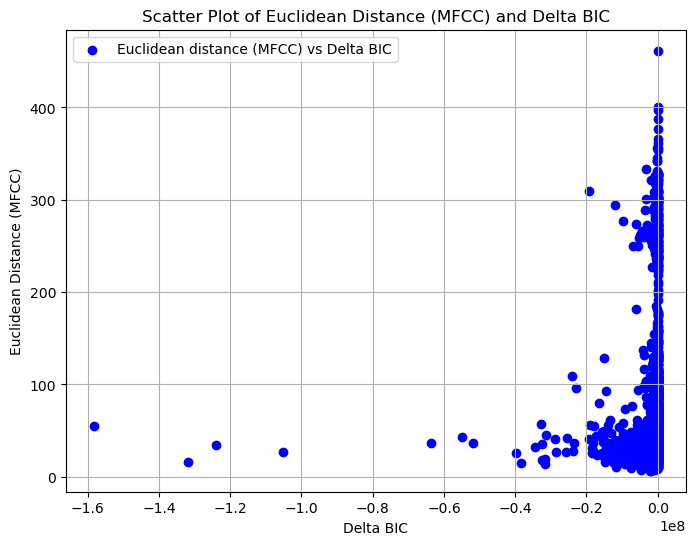

In [9]:
# visualise the data points
#plot the euclidean distance of mfccs and the delta BICs
import matplotlib.pyplot as plt

delta_BICs = pairs_df['delta_BIC_mfcc']

euclidean_distances_mfcc = pairs_df['euclidean_distance_mfcc']

plt.figure(figsize=(8, 6))
plt.scatter(delta_BICs, euclidean_distances_mfcc, color='blue', label='MFCC Euclidean distance vs Delta BIC')

plt.xlabel('Delta BIC')
plt.ylabel('MFCC Euclidean Distance')
plt.title('Scatter Plot of MFCC Euclidean Distance and Delta BIC')
plt.grid(True)
plt.legend()

plt.show()

In [10]:
# obtain the level of correlation by calculating the the value of linear correlation and non-linear correlation
from scipy.stats import pearsonr, spearmanr

# calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(euclidean_distances_mfcc, delta_BICs)
print(f'Linear correlation: {pearson_corr}')

# calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(euclidean_distances_mfcc, delta_BICs)
print(f"Non-linear correlation: {spearman_corr}")

Linear correlation: 0.0823864814995654
Non-linear correlation: 0.3527687686786045


STEP 3.2 : conduct correlation anaylsis between cosine similarities of MFCCs and Delta BICs

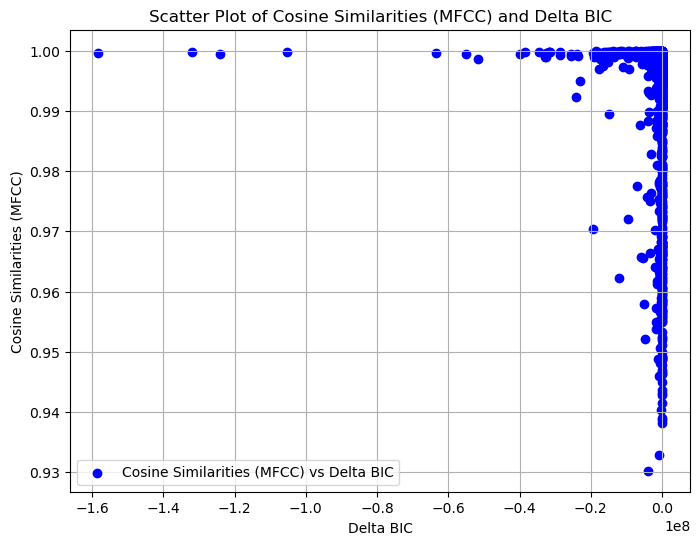

In [12]:
#plot the cosine similarity of mfccs and the delta BICs
cosine_similarities_mfcc = pairs_df['cosine_similarity_mfcc']

plt.figure(figsize=(8, 6))
plt.scatter(delta_BICs, cosine_similarities_mfcc, color='blue', label='MFCC Cosine Similarities vs Delta BIC')

plt.xlabel('Delta BIC')
plt.ylabel('MFCC Cosine Similarities')
plt.title('Scatter Plot of MFCC Cosine Similarities and Delta BIC')
plt.grid(True)
plt.legend()

plt.show()

In [15]:
#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(cosine_similarities_mfcc, delta_BICs)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(cosine_similarities_mfcc, delta_BICs)
print(f"Non-linear correlation: {spearman_corr}")

Linear correlation: -0.06375859935245803
Non-linear correlation: -0.39380588314284487


STEP 3.3 : conduct correlation anaylsis between euclidean distance of xvectors and Delta BICs

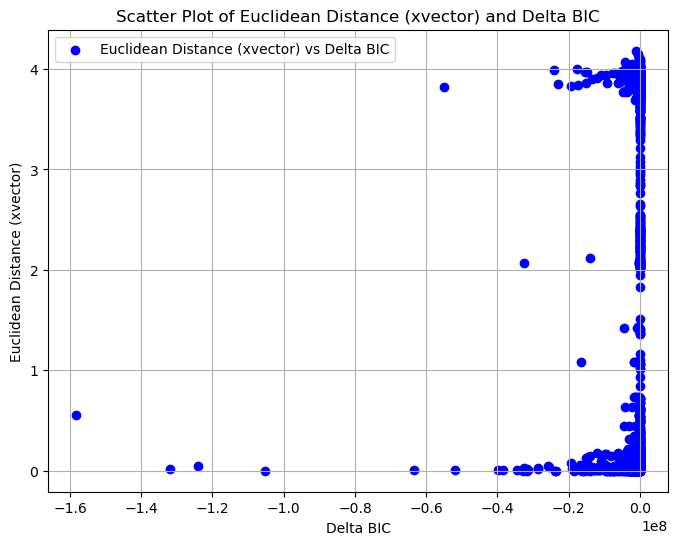

In [16]:
#correlation anaylsis
#plot the euclidean distance of xvectors and the delta BICs
euclidean_distances_xvector = pairs_df['euclidean_distance_xvector']

plt.figure(figsize=(8, 6))
plt.scatter(delta_BICs, euclidean_distances_xvector, color='blue', label='X-Vector Euclidean Distance vs Delta BIC')

plt.xlabel('Delta BIC')
plt.ylabel('X-Vector Euclidean Distance')
plt.title('Scatter Plot of X-Vector Euclidean Distance and Delta BIC')
plt.grid(True)
plt.legend()

plt.show()

In [17]:
#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(euclidean_distances_xvector, delta_BICs)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(euclidean_distances_xvector, delta_BICs)
print(f"Non-linear correlation: {spearman_corr}")

Linear correlation: 0.09100768792510255
Non-linear correlation: 0.33056415611619594


STEP 3.4 : conduct correlation anaylsis between cosine similarities of xvectors and Delta BICs

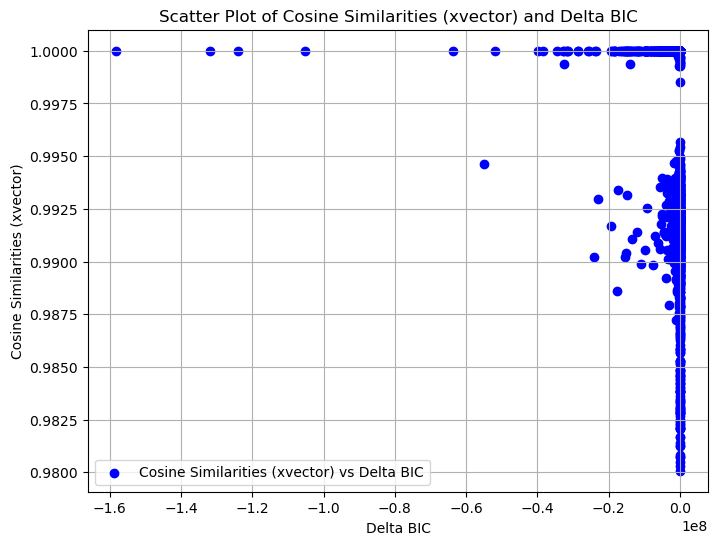

In [18]:
#plot the cosine similarity of xvectors and the delta BICs
cosine_similarities_xvector = pairs_df['cosine_similarity_xvector']

plt.figure(figsize=(8, 6))
plt.scatter(delta_BICs, cosine_similarities_xvector, color='blue', label='X-Vector Cosine Similarities vs Delta BIC')

plt.xlabel('Delta BIC')
plt.ylabel('X-Vector Cosine Similarities')
plt.title('Scatter Plot of X-Vector Cosine Similarities and Delta BIC')
plt.grid(True)
plt.legend()

plt.show()

In [19]:
#calculate the linear correlation level (pearson correlation)
pearson_corr, pearson_p_value = pearsonr(cosine_similarities_xvector, delta_BICs)
print(f'Linear correlation: {pearson_corr}')

#calculate the none-linear correlation level (spearman’s rank correlation)
spearman_corr, spearman_p_value = spearmanr(cosine_similarities_xvector, delta_BICs)
print(f"Non-linear correlation: {spearman_corr}")

Linear correlation: -0.09800282307697257
Non-linear correlation: -0.3767658526708644
